In [7]:
#from google.colab import files
#uploaded = files.upload()

In [8]:
import plotly.express as px
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.distributions.empirical_distribution import ECDF
import datetime
import pandas as pd
import numpy as np


df=pd.read_csv('https://github.com/RCML2016/TimeSeriesAnalysis_StoreProductForecast/blob/master/Sales_Product_Price_by_Store.csv?raw=true',sep=',')
#df


In [9]:
#import io
#df2 = pd.read_csv(io.BytesIO(uploaded['Sales_Product_Price_by_Store.csv']))
# Dataset is now stored in a Pandas Dataframe
#df = pd.read_csv('Sales_Product_Price_by_Store.csv')

In [10]:
df['Date']=pd.to_datetime(df['Date'])
df['weekly_sales']=df['Price'] * df['Weekly_Units_Sold']
df.head()

,Store,Product,Date,Is_Holiday,Base Price,Price,Weekly_Units_Sold,weekly_sales
0,1,1,2010-02-05,False,9.99,7.99,245,1957.55
1,1,1,2010-02-12,True,9.99,7.99,453,3619.47
2,1,1,2010-02-19,False,9.99,7.99,409,3267.91
3,1,1,2010-02-26,False,9.99,7.99,191,1526.09
4,1,1,2010-03-05,False,9.99,9.99,145,1448.55


In [11]:
df.set_index('Date', inplace=True)
df['year']=df.index.year
df['month']=df.index.month
df['day']=df.index.day
df['week_of_year']=df.index.weekofyear
df.head()#

,Store,Product,Is_Holiday,Base Price,Price,Weekly_Units_Sold,weekly_sales,year,month,day,week_of_year
Date,,,,,,,,,,,
2010-02-05,1,1,False,9.99,7.99,245,1957.55,2010,2,5,5
2010-02-12,1,1,True,9.99,7.99,453,3619.47,2010,2,12,6
2010-02-19,1,1,False,9.99,7.99,409,3267.91,2010,2,19,7
2010-02-26,1,1,False,9.99,7.99,191,1526.09,2010,2,26,8
2010-03-05,1,1,False,9.99,9.99,145,1448.55,2010,3,5,9


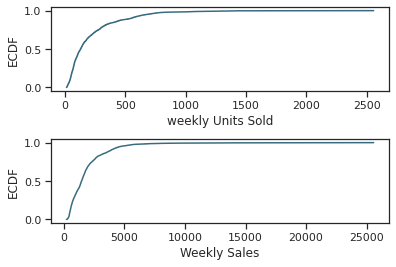

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
c= '#386B7F'
figure, axes=plt.subplots(nrows=2, ncols=2)
figure.tight_layout(pad=2.0)
plt.subplot(211)
cdf=ECDF(df['Weekly_Units_Sold'])
plt.plot(cdf.x,cdf.y,label="statmodels",color=c);
plt.xlabel('weekly Units Sold'); plt.ylabel('ECDF');

plt.subplot(212)
cdf=ECDF(df['weekly_sales'])
plt.plot(cdf.x,cdf.y,label="statmodels",color=c);
plt.xlabel('Weekly Sales'); plt.ylabel('ECDF');

In [13]:
df.groupby('Store')['weekly_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
Store,,,,,,,,
1,429.0,1789.414172,900.074226,769.65,1208.90,1659.17,1957.20,6816.59
2,429.0,2469.447413,1328.162884,1143.48,1579.21,2215.08,2756.55,9110.00
3,429.0,670.924009,366.816321,229.77,459.77,619.69,730.78,2650.00
4,429.0,3078.462145,1746.147872,1099.45,1818.18,2626.61,3837.51,13753.12
5,429.0,588.922984,242.628977,285.87,461.23,519.74,613.53,2264.97
6,429.0,2066.705082,1163.284768,890.19,1418.58,1758.40,2156.40,7936.03
7,429.0,955.115058,489.084883,389.61,649.35,857.61,1041.51,3270.00
8,429.0,1352.094056,811.326288,516.53,846.23,1275.87,1491.51,6656.67
10,429.0,4093.407249,3130.087191,1483.65,2462.88,3707.81,4510.47,25570.00


In [14]:
df.groupby('Store')['Weekly_Units_Sold'].sum()

Store
1      86699
2     121465
3      31689
4     158718
5      27300
6      97698
7      44027
8      65273
10    200924
Name: Weekly_Units_Sold, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:723: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



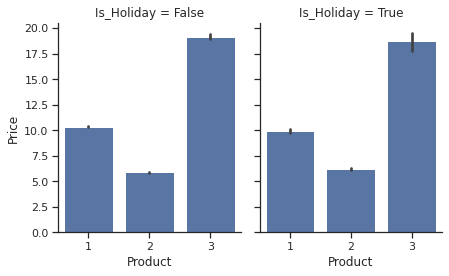

In [15]:
g = sns.FacetGrid(df, col="Is_Holiday", height=4, aspect=.8)
g.map(sns.barplot,"Product","Price")

Product 2 is the cheapest product among these three products, so, it sells the most. Product 3 is the most expensive product among these three. Product price did not change during holidays.

Because we have recorded holidays sales, so we will analyze if holiday also contributed to the sales.

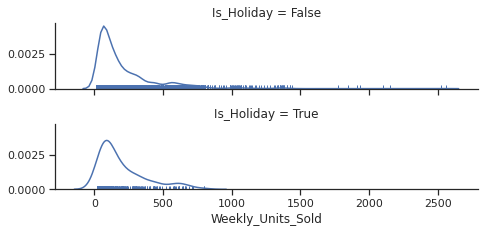

In [16]:
g = sns.FacetGrid(df, row="Is_Holiday",
                  height=1.7, aspect=4,)
g.map(sns.distplot, "Weekly_Units_Sold", hist=False, rug=True)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



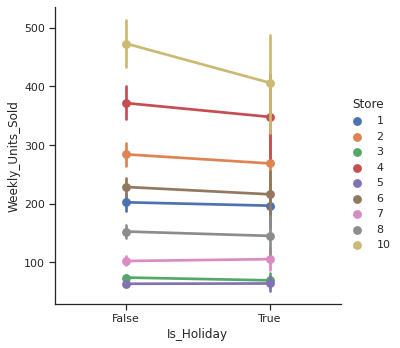

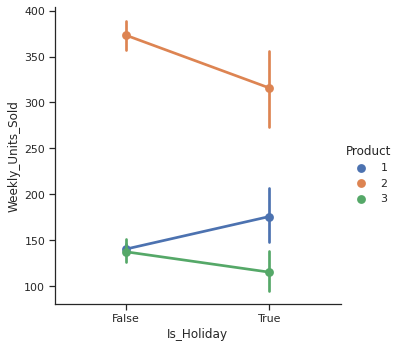

In [17]:
sns.factorplot(data=df,
               x= 'Is_Holiday',
               y='Weekly_Units_Sold',
               hue='Store')

sns.factorplot(data= df, 
               x= 'Is_Holiday',
               y= 'Weekly_Units_Sold',
               hue= 'Product')

From the above figures we can see that holidays do not have a positive impact on the business. For most of the stores, weekly unit sales on the holidays is as same as the normal days, while store 10 also face a decrease in sales during the holidays.

# New Section

Weekly units sold for product 1 had a slightly increase during the holidays, while product 2 and product 3 had a decrease during the holidays.

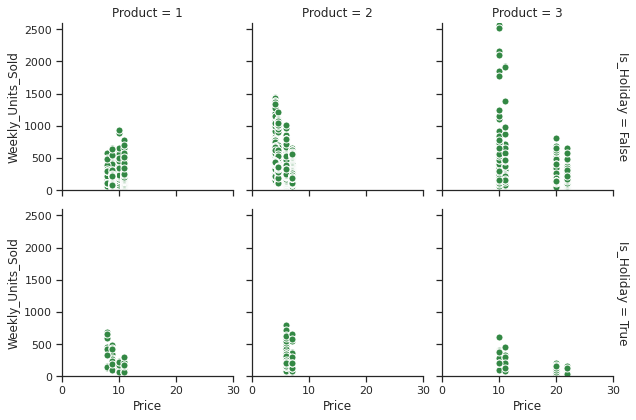

In [18]:
g = sns.FacetGrid(df, col="Product", row="Is_Holiday", margin_titles=True, height=3)
g.map(plt.scatter, "Price", "Weekly_Units_Sold", color="#338844", edgecolor="white", s=50, lw=1)
g.set(xlim=(0, 30), ylim=(0, 2600));

Every product has more than one price, both in holidays and normal days. One price is regular price, and another is a promotional price. However, the price gap for product 3 is huge, it was slashed to almost 50% off during promotions.

Product 3 made the most sales during normal days.



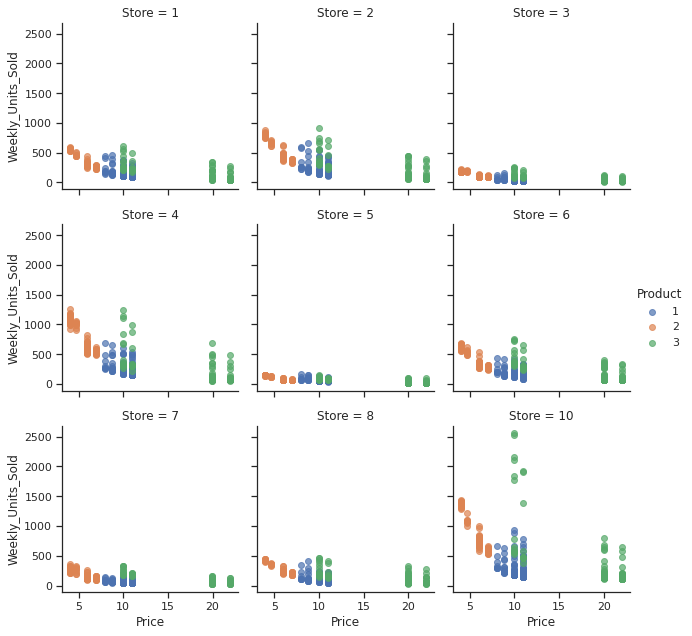

In [19]:
g = sns.FacetGrid(df, col="Store", hue="Product", margin_titles=True, col_wrap=3)
g.map(plt.scatter, 'Price', 'Weekly_Units_Sold', alpha=.7)
g.add_legend()

All the stores have the similar price promotion pattern, for some reason, Store 10 sells the most during the promotions. All the products have the regular price and promotion price. Product 3 has the highest discount and sells the most during the promotions.

In [20]:
#df.groupby(['Product', 'promotion'])['Price', 'Weekly_Units_Sold'].mean()

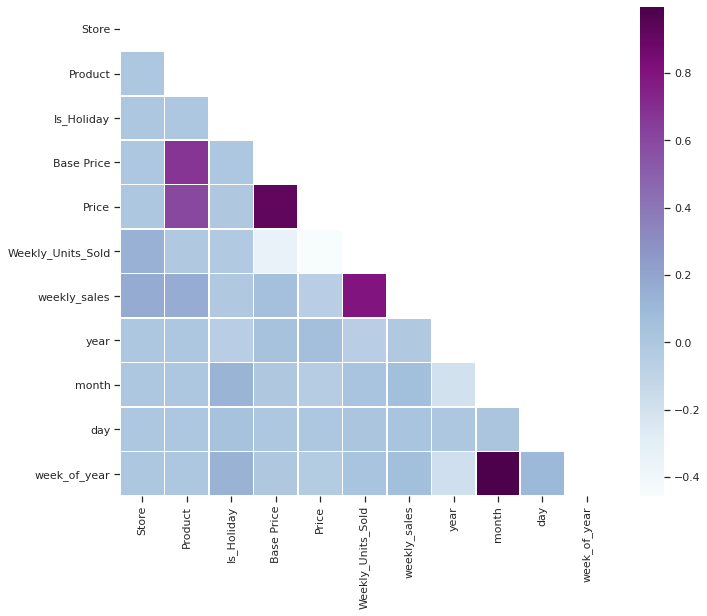

In [21]:
corr_all = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show();

We have a strong positive correlation between price and Base price, weekly units sold and weekly sales, base price and product, price and product. We can also observe a positive correlation between month and week of the year.

Observations of our EDA:

The most selling and crowded Store is Store 10, and the least crowded store is Store 5.
In terms of number of units sold, the most selling product is product 2. In terms of sales dollars, Product 3 posts the highest sales during normal days.
Stores do not necessarily run product promotions during holidays. Holidays do not seem to have an impact on Stores’ performance.
Product 1 sells a little more during holidays, however, Product 2 and Product 3 sell less on holidays.
Product 2 seems to be the cheapest product, and Product 3 is the most expensive product.
Most stores have some kind of seasonality and they make the highest sales around July.
Product 1 sells a little more in February than the other months, Product 2 sells the most around April and July, and Product 3 sells the most around July.
In general, product 2 sells the most at Store 10, but in July, Product 3 has the highest sales in this store.
Each product has its regular price and promotional price. There isn’t significant gap between regular price and promotional price on Product 1 and Product 2, however, Product 3’s promotional price can be slashed to 50% of its original price. Although every store makes this kind of price cut for product 3, Store 10 is the one made the highest sales during the price cut.
It is nothing unusual to sell more during promotion than the normal days. Store 10’s made Product 3 the best selling product around July.

Time Series Forecasting and Sales Prediction
Now let’s move to the Time Series Forecasting Part of this article, here we will forecast sales, according to our above observations of exploratory data analysis.

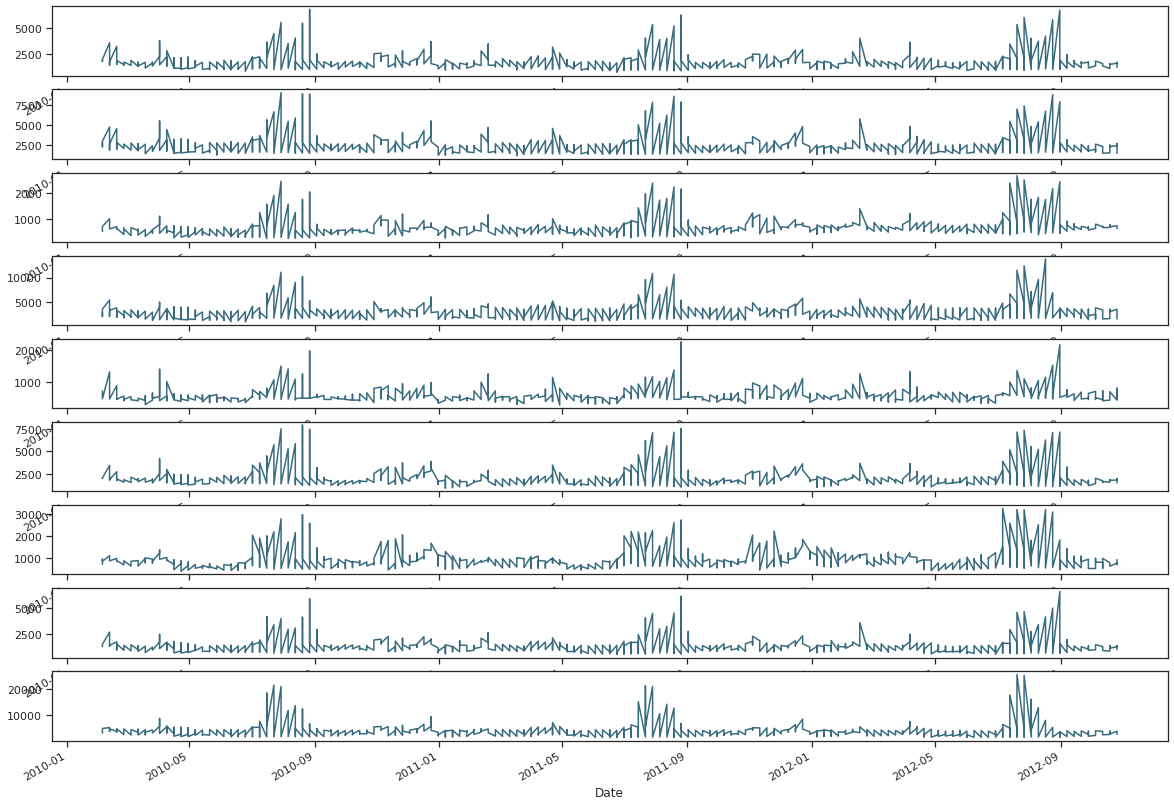

In [22]:
# store types
sales_1 = df[df.Store == 1]['weekly_sales']
sales_2 = df[df.Store == 2]['weekly_sales']
sales_3 = df[df.Store == 3]['weekly_sales']
sales_4 = df[df.Store == 4]['weekly_sales']
sales_5 = df[df.Store == 5]['weekly_sales']
sales_6 = df[df.Store == 6]['weekly_sales']
sales_7 = df[df.Store == 7]['weekly_sales']
sales_8 = df[df.Store == 8]['weekly_sales']
sales_10 = df[df.Store == 10]['weekly_sales']

f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(9, figsize = (20, 15))

# store types
sales_1.plot(color = c, ax = ax1)
sales_2.plot(color = c, ax = ax2)
sales_3.plot(color = c, ax = ax3)
sales_4.plot(color = c, ax = ax4)
sales_5.plot(color = c, ax = ax5)
sales_6.plot(color = c, ax = ax6)
sales_7.plot(color = c, ax = ax7)
sales_8.plot(color = c, ax = ax8)
sales_10.plot(color = c, ax = ax9)

Time Series Forecasting
Time Series of the weekly sales:

In [23]:
store_10_pro_3 = df[(df.Store == 10) & (df.Product == 3)].loc[:, ['Base Price', 'Price', 'Weekly_Units_Sold', 'weekly_sales']]
store_10_pro_3.reset_index(level=0, inplace=True)
fig = px.line(store_10_pro_3, x='Date', y='weekly_sales')
fig.update_layout(title_text='Time Series of weekly sales')
fig.show()

Product 2’s seasonality at store 10 is obvious. The sales always peak between July and September during school holiday. Below we are implementing prophet model, forecasting the weekly sales for the future 50 weeks.

In [24]:
store_10_pro_3 = store_10_pro_3[['Date', 'weekly_sales']].rename(columns = {'Date': 'ds',
                                'weekly_sales': 'y'})

In [25]:
model = Prophet(interval_width = 0.95)
model.fit(store_10_pro_3)

future_dates = model.make_future_dataframe(periods = 50, freq='W')

future_dates.tail(7)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
186,2013-08-25
187,2013-09-01
188,2013-09-08
189,2013-09-15
190,2013-09-22
191,2013-09-29
192,2013-10-06


In [26]:
forecast = model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
186,2013-08-25,7160.453669,4964.110672,9639.888898
187,2013-09-01,5542.434739,3282.556113,8013.020164
188,2013-09-08,3702.168377,1584.494964,6114.479949
189,2013-09-15,2427.279755,155.184897,4879.169449
190,2013-09-22,2386.972428,72.681762,4762.333008
191,2013-09-29,3020.451351,799.949465,5225.838971
192,2013-10-06,3157.655085,830.687590,5341.079553


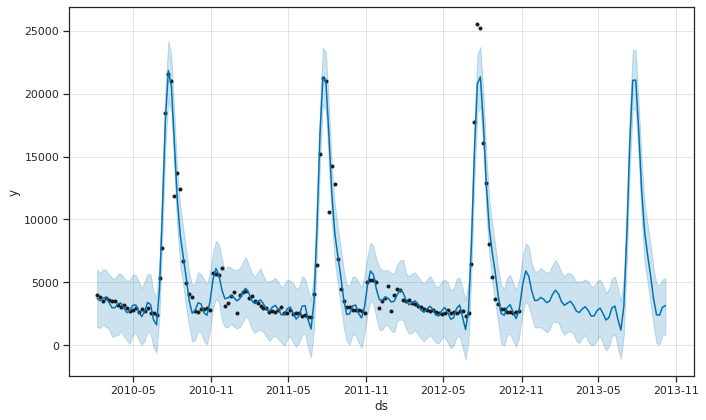

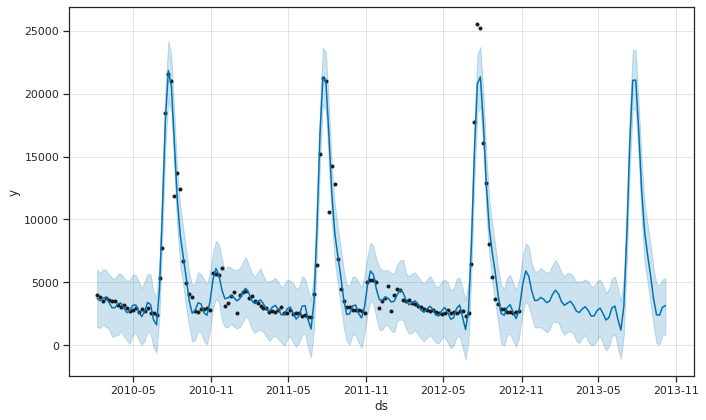

In [27]:
model.plot(forecast)

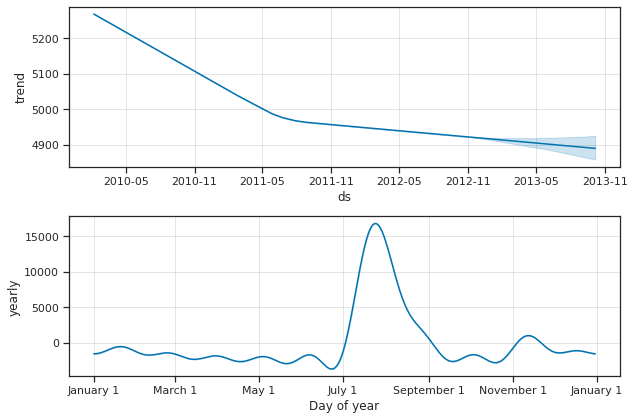

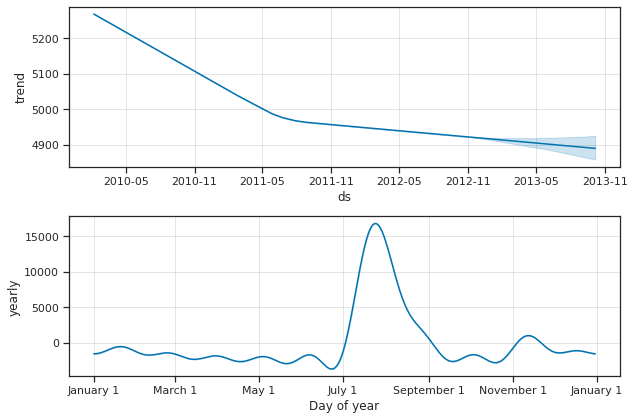

In [28]:
model.plot_components(forecast)

In [29]:
metric_df = forecast.set_index('ds')[['yhat']].join(store_10_pro_3.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
error = mean_squared_error(metric_df.y, metric_df.yhat)
print('The RMSE is {}'. format(sqrt(error)))

The RMSE is 1190.0962582193933
